***
# <center>Generando la estructura de datos necesaria para aplicar <b>mmcIsingCiclovia</b></center> <a class="tocSkip"></a>

Acá pretendo construir un programa genere estructuras de datos de prueba para `mmcIsingCiclovia` a partir de archivos **.geojson** cuyos *features* sean *polígonos*.

# Transformando los datos de las manzanas a DataFrames

In [1]:
using GeoJSON
using DataFrames
manzanas = GeoJSON.parsefile("cdmx_manzanas.geojson")
manz_dict = geo2dict(manzanas);

In [2]:
list_df_manz = []
for i in 1:65993    
    coords_manzi = get(get(get(manz_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    manzi_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_manzi,1)
        push!(manzi_df, coords_manzi[j])
    end
    push!(list_df_manz,manzi_df)
end

El número total de manzanas (65993) lo tuve por fuerza bruta, haciendo el ciclo de la 2da línea
```julia
for i in 1:1000000
```
y observando el error que saltó. Aún no sé cómo encontrar el tamaño de los diccionarios anidados con esa estructura. Las coordenadas de cada manzana están en un `DataFrame` que es elemento de la lista `list_df_manz`. 

## *Paréntesis* Como son muchos datos probablemente convenga tener listo el multithreading

In [3]:
Threads.nthreads()

4

In [4]:
a = zeros(10)
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

10-element Array{Float64,1}:
 1.0
 1.0
 1.0
 2.0
 2.0
 2.0
 3.0
 3.0
 4.0
 4.0

## Una prueba graficando los datos de manzanas dentro de la lista de DataFrames

In [5]:
using PyPlot
using PyCall
plt = pyimport("matplotlib.pyplot")
jtp = pyimport("jupyterthemes.jtplot")
jtp.style(theme="chesterish")

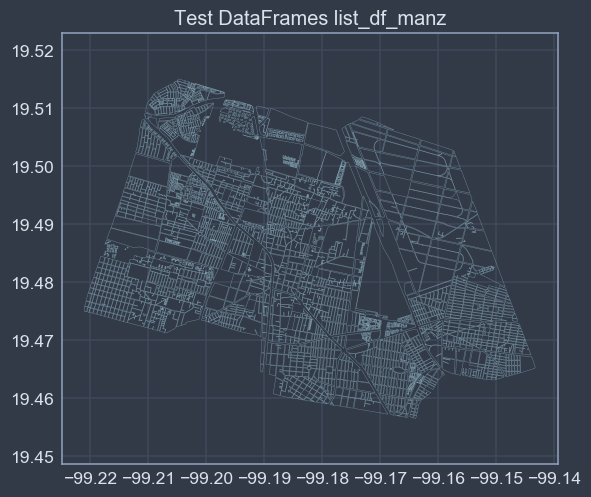

  6.360527 seconds (275.22 k allocations: 12.718 MiB, 0.34% gc time)


In [10]:
@time begin
    
fig = plt.figure()
plt.title("Test DataFrames list_df_manz")

for i in 1:3000
    plt.plot(list_df_manz[i].x, list_df_manz[i].y, "-", color="lightblue", lw=0.3, alpha=0.5);
end
plt.axis("equal")
plt.show()
fig.savefig("Manzanas_test.png", writer="imagemagick")
    
end

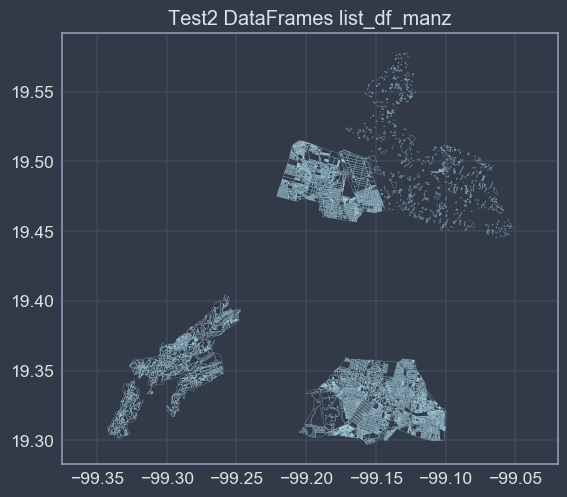

 59.466863 seconds (939.22 k allocations: 42.717 MiB, 0.07% gc time)


In [9]:
@time begin
    
fig = plt.figure()
plt.title("Test2 DataFrames list_df_manz")

for i in 1:10000
    plt.plot(list_df_manz[i].x, list_df_manz[i].y, "-", color="lightblue", lw=0.3, alpha=0.5);
end
plt.axis("equal")
plt.show()
fig.savefig("Manzanas_test2.png", writer="imagemagick")
    
end

Se puede comenzar a ver la diferencia de performance de `matplotlib` al aumentar el número de puntos a graficar este caso. Los ciclos que llaman a `matplotlib` no se pueden hacer con el multithread nativo de Julia (casi que por obvias razones).

Al parecer, hay que estudiar más sobre el orden que pudieran tener los elementos de la lista `list_df_manz`, si es que tiene algún orden. Analizando el primer elemento del .geojson parece que cada manzana tiene asociados los datos:
```
"CVEGEO": "0900200010985032"
"CVE_ENT": "09"
"CVE_MUN": "002"
"CVE_LOC": "0001"
"CVE_AGEB": "0985"
"CVE_MZA": "032"
"AMBITO": "Urbana"
"TIPOMZA": "Contenedora"
```
que pueden ser útiles después, habrá que ver cómo se pueden extraer del diccionario `manz_dict` y asociarlos con la lista.

In [13]:
get(get(manz_dict,"features", 1)[1],"properties",1)

Dict{String,Any} with 8 entries:
  "CVE_ENT"  => "09"
  "CVE_LOC"  => "0001"
  "TIPOMZA"  => "Contenedora"
  "AMBITO"   => "Urbana"
  "CVE_AGEB" => "0985"
  "CVEGEO"   => "0900200010985032"
  "CVE_MUN"  => "002"
  "CVE_MZA"  => "032"

Efectivamente, esas propiedades también están en `manz_dict`.

# Transformando los datos de distritos a DataFrames

In [12]:
distritos = GeoJSON.parsefile("cdmx_distritos.geojson")
dist_dict = geo2dict(distritos);

In [13]:
list_df_dist = []
for i in 1:85
    coords_disti = get(get(get(dist_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    disti_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_disti,1)
        push!(disti_df, coords_disti[j])
    end
    push!(list_df_dist,disti_df)
end

Acá el número de distritos (85), aunque en total son más, la estrutura de los datos me permitió conocer que para la ciudad de méxico sólo son necesarios los *primeros* 85. Las coordenadas de cada distrito están en un `DataFrame` que es elemento de la lista `list_df_dist`, convenientemente ordenada según el mapa del PlanBICI-CDMX.

## Una prueba graficando los datos de distritos dentro de la lista de DataFrames

In [ ]:
bpl = pyimport("bokeh.plotting")
ipd = pyimport("IPython.display");

In [37]:
@time begin

bpl.output_file("distritos.html", mode="inline")
p = bpl.figure(title="D 1-2", aspect_scale=1,
    background_fill_color="#efefef", background_fill_alpha=0.85)
for i in 1:85
    p.line(list_df_dist[i].x, list_df_dist[i].y, color="#323a48", line_width=3, alpha=0.8);
end
bpl.save(p)
ipd = pyimport("IPython.display")
ipd.IFrame(src="distritos.html", width=650, height=680)
    
end

  0.372694 seconds (5.16 k allocations: 257.656 KiB)


PyObject <IPython.lib.display.IFrame object at 0x7f081ba1fbe0>

Graficar con `bokeh` fue suficientemete rápido y con buenos resultados. Habrá que hacer más pruebas, sobre todo con conjuntos de datos mucho más grandes, como los de manzanas.